In [71]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import swifter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import joblib
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

# swifter.config.progress_bar = False

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lemil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lemil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data Understanding

In [34]:
# Load dataset
def load_dataset(file_path):
    dataframe = pd.read_csv(file_path)
    print(f"Dataset berhasil dimuat dengan {len(dataframe)} baris")
    print(f"Kolom yang tersedia: {dataframe.columns.tolist()}")
    return dataframe

data = load_dataset('../../data/main_dataset/dataset_spam_nlp.csv')
data.head(20)

Dataset berhasil dimuat dengan 15000 baris
Kolom yang tersedia: ['ulasan', 'kategori']


,ulasan,kategori
0,promo! promo! https://spamlink1.com,explicit_spam
1,"lambat kayak keong, sering minta rating",genuine_review
2,"ini software pas-pasan parah, terlalu banyak n...",genuine_review
3,cuma mantap mantap mantap,explicit_spam
4,nomor 1! main sekarang! www.mainmenangterus.com,explicit_spam
5,loker model (gaji nego) email karir@spamcorp-g...,explicit_spam
6,"hp saya spek dewa, kira-kira kuat ga ya buat m...",irrelevant_content
7,tolong perbaiki bug tampilan di layar poni yan...,genuine_review
8,kode referral ajaib saya: grabdiskonbaru. luma...,irrelevant_content
9,investasi saham gorengan ipo di www.bisnismuda...,explicit_spam


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ulasan    15000 non-null  object
 1   kategori  15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


In [31]:
data.describe()

,ulasan,kategori
count,15000,15000
unique,15000,3
top,komunitas di forum developer rame isinya maste...,explicit_spam
freq,1,5000


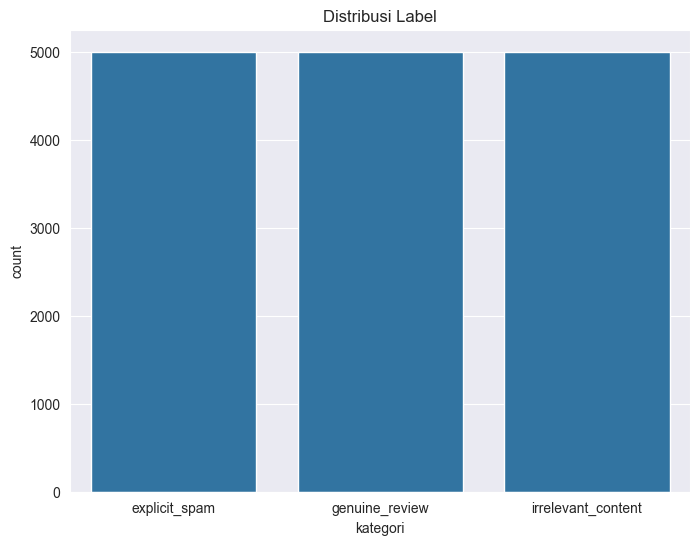

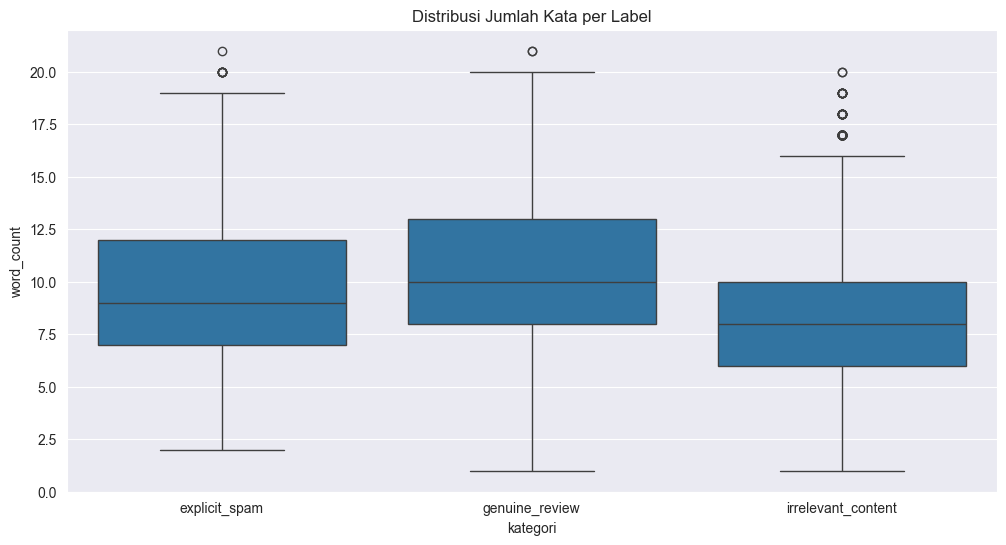

Top words untuk Label explicit_spam: [('di', 1326), ('gratis', 589), ('cek', 462), ('klik', 350), ('game', 337), ('tanpa', 328), ('jasa', 327), ('sekarang!', 315), ('ini', 313), ('cepat', 312), ('jangan', 309), ('diskon', 304), ('obat', 297), ('anda', 291), ('akun', 268), ('murah', 262), ('untuk', 261), ('online', 247), ('terbaru', 245), ('gratis!', 240)]
Top words untuk Label genuine_review: [('tapi', 1127), ('fitur', 926), ('di', 767), ('untuk', 685), ('jadi', 673), ('tidak', 635), ('ini', 590), ('saya', 556), ('update', 526), ('lebih', 501), ('ada', 449), ('sangat', 440), ('dan', 416), ('banyak', 389), ('yang', 379), ('setelah', 366), ('iklan', 357), ('banget', 347), ('proses', 343), ('bisa', 337)]
Top words untuk Label irrelevant_content: [('di', 2202), ('ada', 678), ('saya', 667), ('yang', 624), ('lebih', 563), ('hp', 540), ('ini', 454), ('pakai', 402), ('buat', 370), ('lagi', 365), ('kode', 309), ('lagu', 293), ('-', 283), ('mending', 278), ('nonton', 277), ('sama', 260), ('devel

In [35]:
# Distribusi label
plt.figure(figsize=(8, 6))
sns.countplot(x='kategori', data=data)
plt.title('Distribusi Label')
plt.show()

# Analisis panjang teks
data['text_length'] = data['ulasan'].apply(len)
data['word_count'] = data['ulasan'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='kategori', y='word_count', data=data)
plt.title('Distribusi Jumlah Kata per Label')
plt.show()

# Analisis kata umum per kategori
def get_top_words(texts, n=20):
    words = ' '.join(texts).lower().split()
    return Counter(words).most_common(n)

# Top words per label
for label in data['kategori'].unique():
    top_words = get_top_words(data[data['kategori'] == label]['ulasan'])
    print(f"Top words untuk Label {label}: {top_words}")

# 2. Data Preprocessing

In [36]:
def cleaningUlasan(ulasan):
    ulasan = ulasan.strip().lower()

    # Hapus mention dan hashtag
    ulasan = re.sub(r'@[A-Za-z0-9_]+', ' ', ulasan)
    ulasan = re.sub(r'#[A-Za-z0-9_]+', ' ', ulasan)

    # Hapus URL
    ulasan = re.sub(
        r'''
        (?i)\b
        (?:https?://|ftp://|www\.)
        (?:[a-z0-9](?:[a-z0-9-]{0,61}[a-z0-9])?\.)+
        [a-z]{2,63}
        (?::\d+)?
        (?:/[^\s()<>]+|\([^\s()<>]+\))*
        ''',
        ' ',
        ulasan,
        flags=re.VERBOSE
    )

    # Hapus token (cont), lanjut, dll
    ulasan = re.sub(r'\(cont\)|lanjut(?:kan)?|lihat selengkapnya|see more', ' ', ulasan, flags=re.IGNORECASE)

    # Hapus angka
    ulasan = re.sub(r'\d+', ' ', ulasan)

    # Hapus karakter non-ASCII
    ulasan = re.sub(r'[^\x00-\x7F]+', ' ', ulasan)

    # Hapus karakter spesial, pertahankan tanda tanya
    ulasan = re.sub(r'[^\w\s]', ' ', ulasan)

    # Hapus whitespace berlebih
    ulasan = re.sub(r'\s+', ' ', ulasan).strip()

    return ulasan

data['clean_text'] = data['ulasan'].swifter.apply(cleaningUlasan)
data[['ulasan', 'clean_text', 'kategori']]

Pandas Apply:   0%|          | 0/15000 [00:00<?, ?it/s]

,ulasan,clean_text,kategori
0,promo! promo! https://spamlink1.com,promo promo,explicit_spam
1,"lambat kayak keong, sering minta rating",lambat kayak keong sering minta rating,genuine_review
2,"ini software pas-pasan parah, terlalu banyak n...",ini software pas pasan parah terlalu banyak no...,genuine_review
3,cuma mantap mantap mantap,cuma mantap mantap mantap,explicit_spam
4,nomor 1! main sekarang! www.mainmenangterus.com,nomor main sekarang,explicit_spam
...,...,...,...
14995,DAPATKAN uang tunai 1 juta GRATIS!!! KLIK LINK...,dapatkan uang tunai juta gratis klik link di b...,explicit_spam
14996,performa kecepatan upload file perlu performa ...,performa kecepatan upload file perlu performa ...,genuine_review
14997,membantu jadi lebih produktif kerja dari rumah...,membantu jadi lebih produktif kerja dari rumah...,genuine_review
14998,obat obat jerawat ampuh atasi kolesterol tingg...,obat obat jerawat ampuh atasi kolesterol tingg...,explicit_spam


In [37]:
print("Apakah ada NaN di dataset?")
print(data.isna().any().any())

print("\nJumlah NaN di setiap kolom:")
print(data.isna().sum())

print("\nPersentase NaN di setiap kolom:")
print((data.isna().mean() * 100).round(2))

print("\nContoh baris yang mengandung NaN:")
print(data[data.isna().any(axis=1)].head())

print("\nTotal seluruh nilai NaN dalam dataset:")
print(data.isna().sum().sum())

print("\nKolom yang memiliki NaN:")
cols_with_nan = data.columns[data.isna().any()].tolist()
print(cols_with_nan)

Apakah ada NaN di dataset?
False

Jumlah NaN di setiap kolom:
ulasan         0
kategori       0
text_length    0
word_count     0
clean_text     0
dtype: int64

Persentase NaN di setiap kolom:
ulasan         0.0
kategori       0.0
text_length    0.0
word_count     0.0
clean_text     0.0
dtype: float64

Contoh baris yang mengandung NaN:
Empty DataFrame
Columns: [ulasan, kategori, text_length, word_count, clean_text]
Index: []

Total seluruh nilai NaN dalam dataset:
0

Kolom yang memiliki NaN:
[]


In [38]:
# Normalisasi slang word
from collections import defaultdict
import json

perubahan_kata = defaultdict(int)
kata_terganti = set()

def resolve_slang(slang_word, slang_dict, max_depth=10):
    original_word = slang_word
    current_word = slang_word
    visited_in_chain = {current_word} # Untuk deteksi siklus dalam rantai ini
    depth = 0

    # Terus cari pengganti selama kata saat ini ada di kamus dan belum melewati batas kedalaman
    while current_word in slang_dict and depth < max_depth:
        next_word = slang_dict[current_word]

        # Jika penggantinya sama dengan kata saat ini (self-loop), hentikan
        if next_word == current_word:
            # print(f"Peringatan: Self-loop terdeteksi untuk '{current_word}'. Menghentikan resolusi.")
            break

        # Jika penggantinya sudah pernah muncul dalam rantai ini (siklus), hentikan
        if next_word in visited_in_chain:
            # print(f"Peringatan: Siklus terdeteksi saat me-resolve '{original_word}'. Rantai: {visited_in_chain}. Berhenti di '{current_word}'.")
            break # Siklus terdeteksi

        # Lanjut ke kata berikutnya
        current_word = next_word
        visited_in_chain.add(current_word)
        depth += 1

    # Beri peringatan jika kedalaman maksimum tercapai sebelum resolusi selesai
    if depth == max_depth and original_word in slang_dict:
        # print(f"Peringatan: Kedalaman resolusi maksimum ({max_depth}) tercapai untuk '{original_word}'. Menggunakan kata terakhir: '{current_word}'.")
        pass

    # Kembalikan kata yang sudah diresolusi (atau kata asli jika tidak ada di dict)
    return current_word

def indo_slang_normalization(teks, slang_dict):
    kata_kata = teks.split()
    normalized_kata_kata = []

    for kata in kata_kata:
        original_kata = kata

        # Periksa apakah kata asli ada di kamus slang
        if original_kata in slang_dict:
            # Cari bentuk normal terakhirnya
            final_normal_word = resolve_slang(original_kata, slang_dict)

            # Tambahkan bentuk normal terakhir ke hasil
            normalized_kata_kata.append(final_normal_word)

            # Catat perubahan HANYA jika kata benar-benar berubah
            if final_normal_word != original_kata:
                # Gunakan variabel global seperti di kode asli
                perubahan_kata[original_kata] += 1
                kata_terganti.add((original_kata, final_normal_word))
        else:
            # Jika kata tidak ada di kamus slang, tambahkan kata asli
            normalized_kata_kata.append(original_kata)

    # Gabungkan kembali kata-kata menjadi teks
    return ' '.join(normalized_kata_kata)

merged_slang_file = '../../data/slang/merged_slang_dict.json'

try:
    with open(merged_slang_file, 'r', encoding='utf-8') as f:
        slang_dict = json.load(f)
    print(f"Kamus slang berhasil dimuat dari {merged_slang_file}")
except FileNotFoundError:
    print(f"Info: File '{merged_slang_file}' tidak ditemukan")

except json.JSONDecodeError:
    print(f"Error: Gagal membaca JSON dari '{merged_slang_file}'. Pastikan formatnya benar.")
    slang_dict = {}

Kamus slang berhasil dimuat dari ../../data/slang/merged_slang_dict.json


In [39]:
# Apply ke dataframe
data['clean_text'] = data['clean_text'].swifter.apply(lambda x: indo_slang_normalization(x, slang_dict))

# Ringkasan perubahannya
print(f"Total kata slang yang terganti: {sum(perubahan_kata.values())}")
print("Contoh kata slang yang terganti:")
for slang, normal in list(kata_terganti)[:10]:
    print(f"{slang} → {normal}")

Pandas Apply:   0%|          | 0/15000 [00:00<?, ?it/s]

Total kata slang yang terganti: 16210
Contoh kata slang yang terganti:
doang → saja
sumatera → sumatra
jadul → jaman dulu
hrd → human resources departement
segini → begini
jiexpo → jakarta international expo
gaptek → gagap teknologi
bersihkan → bersih
tambahin → tambahkan
nego → negosiasi


In [40]:
# List semua kata yang terganti
print(f"Total kata slang yang terganti: {sum(perubahan_kata.values())}")
print("Seluruh kata slang yang terganti:")
for slang, normal in list(kata_terganti):
    print(f"{slang} → {normal}")

Total kata slang yang terganti: 16210
Seluruh kata slang yang terganti:
doang → saja
sumatera → sumatra
jadul → jaman dulu
hrd → human resources departement
segini → begini
jiexpo → jakarta international expo
gaptek → gagap teknologi
bersihkan → bersih
tambahin → tambahkan
nego → negosiasi
disini → di sini
masukkan → masukan
word → kata
rb → ribu
trending → mengetren
cepet → cepat
ig → instagram
gan → juragan
bca → baca
overall → keseluruhan
time → waktu
bro → saudara laki laki
kosan → indekos
ngedit → mengedit
store → toko
numpuk → menumpuk
ngatur → mengatur
logout → keluar
pro → profesional
kaya → mirip
tuh → itu
dengerin → dengarkan
rame → ramai
pln → perusahaan listrik negara
smart → pintar
jutek → galak
resiko → risiko
nunggu → menunggu
bokep → porno
syariah → syariat
lansia → lanjut usia
call → telepon
mlm → malam
gadget → gawai
tren → trend
cs → rekan
org → orang
ucapin → mengucapkan
aamiin → amin
phone → seluler
mantul → mantap betul
hpnya → handphonenya
pen → ingin
haters → ha

In [41]:
data[['ulasan', 'clean_text', 'kategori']]

,ulasan,clean_text,kategori
0,promo! promo! https://spamlink1.com,promo promo,explicit_spam
1,"lambat kayak keong, sering minta rating",lambat mirip keong sering meminta rating,genuine_review
2,"ini software pas-pasan parah, terlalu banyak n...",ini software pas pasan parah terlalu banyak no...,genuine_review
3,cuma mantap mantap mantap,cuma mantap mantap mantap,explicit_spam
4,nomor 1! main sekarang! www.mainmenangterus.com,nomor main sekarang,explicit_spam
...,...,...,...
14995,DAPATKAN uang tunai 1 juta GRATIS!!! KLIK LINK...,dapatkan uang tunai juta gratis klik link di b...,explicit_spam
14996,performa kecepatan upload file perlu performa ...,performa kecepatan unggah file perlu performa ...,genuine_review
14997,membantu jadi lebih produktif kerja dari rumah...,membantu jadi lebih produktif kerja dari rumah...,genuine_review
14998,obat obat jerawat ampuh atasi kolesterol tingg...,obat obat jerawat ampuh atasi kolesterol tingg...,explicit_spam


In [42]:
print("Apakah ada NaN di dataset?")
print(data.isna().any().any())

print("\nJumlah NaN di setiap kolom:")
print(data.isna().sum())

print("\nPersentase NaN di setiap kolom:")
print((data.isna().mean() * 100).round(2))

print("\nContoh baris yang mengandung NaN:")
print(data[data.isna().any(axis=1)].head())

print("\nTotal seluruh nilai NaN dalam dataset:")
print(data.isna().sum().sum())

print("\nKolom yang memiliki NaN:")
cols_with_nan = data.columns[data.isna().any()].tolist()
print(cols_with_nan)

Apakah ada NaN di dataset?
False

Jumlah NaN di setiap kolom:
ulasan         0
kategori       0
text_length    0
word_count     0
clean_text     0
dtype: int64

Persentase NaN di setiap kolom:
ulasan         0.0
kategori       0.0
text_length    0.0
word_count     0.0
clean_text     0.0
dtype: float64

Contoh baris yang mengandung NaN:
Empty DataFrame
Columns: [ulasan, kategori, text_length, word_count, clean_text]
Index: []

Total seluruh nilai NaN dalam dataset:
0

Kolom yang memiliki NaN:
[]


In [43]:
# Tokenization
def tokenize_text(teks):
    tokens = word_tokenize(teks)
    return ' '.join(tokens)

data['clean_text'] = data['clean_text'].swifter.apply(tokenize_text)
data[['ulasan', 'clean_text', 'kategori']]

Pandas Apply:   0%|          | 0/15000 [00:00<?, ?it/s]

,ulasan,clean_text,kategori
0,promo! promo! https://spamlink1.com,promo promo,explicit_spam
1,"lambat kayak keong, sering minta rating",lambat mirip keong sering meminta rating,genuine_review
2,"ini software pas-pasan parah, terlalu banyak n...",ini software pas pasan parah terlalu banyak no...,genuine_review
3,cuma mantap mantap mantap,cuma mantap mantap mantap,explicit_spam
4,nomor 1! main sekarang! www.mainmenangterus.com,nomor main sekarang,explicit_spam
...,...,...,...
14995,DAPATKAN uang tunai 1 juta GRATIS!!! KLIK LINK...,dapatkan uang tunai juta gratis klik link di b...,explicit_spam
14996,performa kecepatan upload file perlu performa ...,performa kecepatan unggah file perlu performa ...,genuine_review
14997,membantu jadi lebih produktif kerja dari rumah...,membantu jadi lebih produktif kerja dari rumah...,genuine_review
14998,obat obat jerawat ampuh atasi kolesterol tingg...,obat obat jerawat ampuh atasi kolesterol tingg...,explicit_spam


In [44]:
# Menghapus stopwords
stop_words = set(stopwords.words('indonesian'))

def remove_stopwords(teks):
    teks = ' '.join([word for word in teks.split() if word not in stop_words])
    return teks

data['clean_text'] = data['clean_text'].swifter.apply(remove_stopwords)
data[['ulasan', 'clean_text', 'kategori']]

Pandas Apply:   0%|          | 0/15000 [00:00<?, ?it/s]

,ulasan,clean_text,kategori
0,promo! promo! https://spamlink1.com,promo promo,explicit_spam
1,"lambat kayak keong, sering minta rating",lambat keong rating,genuine_review
2,"ini software pas-pasan parah, terlalu banyak n...",software pas pasan parah notifikasi menyesal p...,genuine_review
3,cuma mantap mantap mantap,mantap mantap mantap,explicit_spam
4,nomor 1! main sekarang! www.mainmenangterus.com,nomor main,explicit_spam
...,...,...,...
14995,DAPATKAN uang tunai 1 juta GRATIS!!! KLIK LINK...,dapatkan uang tunai juta gratis klik link bio,explicit_spam
14996,performa kecepatan upload file perlu performa ...,performa kecepatan unggah file performa diting...,genuine_review
14997,membantu jadi lebih produktif kerja dari rumah...,membantu produktif kerja rumah koneksi fitur o...,genuine_review
14998,obat obat jerawat ampuh atasi kolesterol tingg...,obat obat jerawat ampuh atasi kolesterol hubungi,explicit_spam


In [45]:
# Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_text(text):
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(tok) for tok in tokens]
    return " ".join(stemmed_tokens)

data['clean_text'] = data['clean_text'].swifter.apply(stem_text)
data[['ulasan', 'clean_text', 'kategori']]

Pandas Apply:   0%|          | 0/15000 [00:00<?, ?it/s]

,ulasan,clean_text,kategori
0,promo! promo! https://spamlink1.com,promo promo,explicit_spam
1,"lambat kayak keong, sering minta rating",lambat keong rating,genuine_review
2,"ini software pas-pasan parah, terlalu banyak n...",software pas pas parah notifikasi sesal pasang,genuine_review
3,cuma mantap mantap mantap,mantap mantap mantap,explicit_spam
4,nomor 1! main sekarang! www.mainmenangterus.com,nomor main,explicit_spam
...,...,...,...
14995,DAPATKAN uang tunai 1 juta GRATIS!!! KLIK LINK...,dapat uang tunai juta gratis klik link bio,explicit_spam
14996,performa kecepatan upload file perlu performa ...,performa cepat unggah file performa tingkat,genuine_review
14997,membantu jadi lebih produktif kerja dari rumah...,bantu produktif kerja rumah koneksi fitur offl...,genuine_review
14998,obat obat jerawat ampuh atasi kolesterol tingg...,obat obat jerawat ampuh atas kolesterol hubung,explicit_spam


# 3. Feature Engineering, Label Encoding, Creating Pipeline

## 3.1 Preprocessing and TF-IDF Pipeline

In [47]:
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

# Sastrawi Stemmer Initialization
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Slang Dictionary Loading
perubahan_kata = defaultdict(int)
try:
    with open('../../data/slang/merged_slang_dict.json', 'r', encoding='utf-8') as f:
        SLANG_DICT = json.load(f)
    print("Kamus slang berhasil dimuat.")
except FileNotFoundError:
    print("Warning: File kamus slang tidak ditemukan. Normalisasi slang tidak akan efektif.")
    SLANG_DICT = {}
except json.JSONDecodeError:
    print("Warning: Gagal membaca file JSON kamus slang. Format mungkin salah.")
    SLANG_DICT = {}
except Exception as e:
    print(f"Warning: Terjadi error saat memuat kamus slang: {e}")
    SLANG_DICT = {}

Kamus slang berhasil dimuat.


In [48]:
def resolve_slang(w, d, max_depth=10):
    curr, seen, depth = w, {w}, 0
    while curr in d and depth<max_depth:
        nxt = d[curr]
        if nxt in seen or nxt==curr: break
        seen.add(nxt); curr, depth = nxt, depth+1
    return curr

def cleaningUlasan(text):
    text = text.strip().lower()
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text)
    text = re.sub(
        r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+\.[a-z]{2,4}/)
        (?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+
        (?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''',
        ' ',
        text,
        flags=re.VERBOSE
    )
    text = re.sub(r'\(cont\)|lanjut(?:kan)?|lihat selengkapnya|see more', ' ', text, flags=re.IGNORECASE)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def normalize_slang(text):
    toks, out = text.split(), []
    for w in toks:
        norm = resolve_slang(w, SLANG_DICT)
        out.append(norm)
    return ' '.join(out)

def remove_stopwords(text):
    stops = set(stopwords.words('indonesian'))
    return ' '.join([w for w in text.split() if w not in stops])

def stem_text(text):
    return ' '.join(stemmer.stem(w) for w in text.split())

class IndoTextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X, y=None):
        s1 = X.swifter.apply(cleaningUlasan)
        s2 = s1.swifter.apply(normalize_slang)
        s3 = s2.swifter.apply(lambda t: ' '.join(word_tokenize(t)))
        s4 = s3.swifter.apply(remove_stopwords)
        return s4.swifter.apply(stem_text)

In [49]:
text_pipeline = Pipeline([
    ('preproc', IndoTextPreprocessor()),
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.8,
        ngram_range=(1, 2)
    ))
])

print("Text feature pipeline defined:")
print(text_pipeline)

Text feature pipeline defined:
Pipeline(steps=[('preproc', IndoTextPreprocessor()),
                ('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=5000, min_df=5,
                                 ngram_range=(1, 2)))])


## 3.2 Statistical features

In [50]:
URL_RE = re.compile(
    r"""
    (?i)\b
    (?:https?://|ftp://|www\.)
    (?:[a-z0-9](?:[a-z0-9-]{0,61}[a-z0-9])?\.)+
    [a-z]{2,63}
    (?::\d+)?
    (?:/[^\s()<>]+|\([^\s()<>]+\))*
    """,
    re.VERBOSE | re.IGNORECASE
)
PHONE_RE     = re.compile(r'(08\d{8,11}|\+62\d{8,11}|0\d{9,12})')
EMAIL_RE     = re.compile(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}', re.IGNORECASE)
MENTION_RE   = re.compile(r'@\w+')
CHAR_REP_RE  = re.compile(r'(.)\1{4,}')
EMOJI_REP_RE = re.compile(r'([\U00010000-\U0010ffff\u2600-\u27BF])\1{4,}', re.UNICODE)
CON_RE       = re.compile(r'[bcdfghjklmnpqrstvwxyz]', re.IGNORECASE)
VOW_RE       = re.compile(r'[aeiou]', re.IGNORECASE)
PROMO_RE     = re.compile(r'(?:kode|promo|referral)\s+\w{4,}', re.IGNORECASE)

# Word Sets
COMPARISON_WORDS = {
    'dibanding', 'daripada', 'ketimbang', 'lebih', 'kurang', 'dari', 'mending',
    'mirip', 'beda', 'berbeda', 'seperti', 'vs', 'versus', 'dibandingkan',
    'setara', 'kalah', 'unggul', 'bagusan', 'tidak seperti', 'sama', 'persis',
    'alternatif', 'kompetitor', 'saingan', 'sejenis'
}
QUESTION_WORDS = {
    'bagaimana', 'kenapa', 'mengapa', 'gimana', 'apakah', 'siapa', 'dimana',
    'kapan', 'berapa', 'kok', 'gmn' 'masa', 'beneran', 'serius', 'tolong', 'bantu',
    'mohon', 'ada', 'punya', 'bolehkah', 'kapanlagi', 'caranya',
    'solusinya', 'tipsnya', 'triknya', 'tutorialnya', 'panduannya', 'artinya',
    'maksudnya', 'fungsinya', 'gunanya', 'rekomendasi', 'saran', 'info', 'tanya',
    'nanya', 'bertanya', 'kah', 'tah', 'siapakah', 'kapankah', 'dimanakah',
    'bagaimanakah', 'berapakah', 'bisakah', 'bolehkah', 'dapatkah', 'mungkinkah',
    'haruskah', 'perlukah', 'adakah', 'bilamanakah', 'seberapakah'
}
OFF_TOPIC_KEYS = {
    # Politik, Berita, Isu Sosial
    'politik', 'pemilu', 'pilpres', 'pilkada', 'partai', 'capres', 'cawapres',
    'berita', 'viral', 'trending', 'korupsi', 'hukum', 'pemerintah', 'dpr',
    'harga', 'bbm', 'inflasi', 'ekonomi', 'saham', 'crypto', 'bitcoin', 'nft',
    'cuaca', 'hujan', 'panas', 'banjir', 'gempa',
    # Olahraga
    'sepakbola', 'bola', 'liga', 'timnas', 'persib', 'persija', 'mu', 'madrid',
    'motogp', 'f1', 'badminton', 'basket',
    # Sapaan, Meta-comment, Informalitas
    'pertamax', 'halo', 'admin', 'hai', 'pagi', 'siang', 'sore', 'malam',
    'assalamualaikum', 'permisi', 'numpang', 'nyimak', 'komen', 'tes', 'test',
    'jejak', 'salam', 'kenal', 'gan', 'min', 'sis', 'bro', 'kak', 'om', 'tan',
    'sundul', 'wkwk', 'haha', 'xixi', 'hehe', 'lol', 'mantap', 'ok', 'oke', 'sip',
    # Aplikasi/Layanan Lain (Contoh Populer)
    'gojek', 'grab', 'shopee', 'tokopedia', 'lazada', 'tiktok', 'instagram',
    'ig', 'wa', 'whatsapp', 'facebook', 'fb', 'twitter', 'x', 'youtube', 'yt',
    'netflix', 'spotify', 'dana', 'ovo', 'gopay', 'pinjol', 'ojol',
    # Kebutuhan/Aktivitas Pribadi/Umum
    'loker', 'lowongan', 'kerja', 'resep', 'masak', 'makan', 'minum', 'film',
    'lagu', 'musik', 'jalan', 'macet', 'rumah', 'sekolah', 'kuliah', 'kampus',
    'tugas', 'skripsi', 'curhat', 'jual', 'beli', 'butuh', 'cari', 'sewa',
    'liburan', 'traveling', 'nonton', 'main', # 'game' bisa relevan, tapi sering juga off-topic
    'tidur', 'mandi', 'kucing', 'anjing' # Contoh hewan peliharaan
}
APP_TERMS = {
    # Istilah Umum Aplikasi/Software
    'aplikasi', 'app', 'software', 'program', 'platform', 'tools', 'utilitas',
    'sistem', 'layanan', 'produk',
    # Fitur & Fungsi
    'fitur', 'fungsi', 'menu', 'opsi', 'tombol', 'navigasi', 'pengaturan',
    'setting', 'konfigurasi', 'tool', 'widget', 'plugin', 'ekstensi', 'api',
    'integrasi', 'kompatibilitas', 'kustomisasi', 'template', 'filter', 'efek',
    'preset', 'tema', 'mode', 'darkmode', 'lightmode', 'offline', 'online',
    'pencarian', 'search', 'sortir', 'filterisasi', 'notifikasi', 'pemberitahuan',
    'alert', 'reminder', 'ai', 'kecerdasan buatan', 'otomatis', 'manual',
    # Update & Versi
    'update', 'upgrade', 'versi', 'rilis', 'build', 'patch', 'baru', 'lama',
    'terbaru', 'sebelumnya', 'beta', 'alpha', 'pro', 'lite', 'premium', 'gratis',
    'freemium', 'berbayar', 'trial', 'percobaan',
    # Antarmuka & Pengalaman Pengguna
    'ui', 'ux', 'tampilan', 'desain', 'interface', 'antarmuka', 'layout',
    'grafis', 'visual', 'animasi', 'transisi', 'intuitif', 'user-friendly',
    'mudah', 'sulit', 'ribet', 'simpel', 'responsif', 'cepat', 'lambat', 'lag',
    'nge-lag', 'smooth', 'patah-patah',
    # Akun & Keamanan
    'login', 'logout', 'signin', 'signup', 'daftar', 'akun', 'profil', 'user',
    'pengguna', 'password', 'sandi', 'otp', 'verifikasi', 'autentikasi',
    'keamanan', 'privasi', 'data', 'enkripsi', 'izin', 'permission',
    # Masalah Teknis
    'bug', 'error', 'crash', 'force close', 'fc', 'hang', 'freeze', 'macet',
    'not responding', 'masalah', 'kendala', 'gangguan', 'problem', 'issue',
    'glitch', 'corrupt', 'kompatibel', 'stabil', 'tidak stabil',
    # Proses & Operasi
    'ekspor', 'impor', 'simpan', 'save', 'buka', 'open', 'tutup', 'close',
    'install', 'uninstall', 'download', 'upload', 'render', 'proses', 'loading',
    'backup', 'restore', 'sinkronisasi', 'sync', 'edit', 'hapus', 'delete',
    'buat', 'create', 'copy', 'paste', 'cut', 'undo', 'redo', 'scan', 'print',
    # Perangkat & OS
    'device', 'perangkat', 'hp', 'ponsel', 'smartphone', 'tablet', 'pc', 'laptop',
    'komputer', 'android', 'ios', 'windows', 'macos', 'web', 'browser',
    # Konten & Data
    'file', 'dokumen', 'gambar', 'foto', 'video', 'audio', 'musik', 'teks',
    'konten', 'data', 'database', 'cloud', 'storage', 'memori', 'ram', 'cpu',
    'baterai', 'kuota', 'internet', 'wifi', 'jaringan',
    # Langganan & Pembayaran
    'langganan', 'subscribe', 'subscription', 'harga', 'biaya', 'bayar',
    'pembayaran', 'transaksi', 'iklan', 'ads', 'watermark', 'lisensi',
    # Game Spesifik (jika relevan)
    'game', 'level', 'karakter', 'item', 'skin', 'map', 'server', 'player',
    'multiplayer', 'singleplayer', 'online', 'offline', 'mabar', 'rank', 'cheat',
    'mod', 'joki', 'topup', 'diamond', 'coin', 'gold', 'uc', # Contoh mata uang game
}
HYPERBOLIC_WORDS = {
    'terbaik', 'tercanggih', 'paling', 'diskon', 'gratis', 'hebat', 'luar', 'biasa',
    'nomor', 'tercepat', 'termurah', 'terhebat', 'fantastis', 'ultimate', 'sempurna',
    'revolusioner', 'terkeren', 'terpopuler', 'terpercaya', 'sekali', 'amat', 'benar-benar',
    'sungguh', '#1', 'juara', 'dewa', 'spektakuler', 'menakjubkan', 'mengagumkan',
    'istimewa', '100%', 'hancur', 'terburuk', 'menyesatkan', 'ajaib', 'super', 'mega', 'gila',
    'gokil', 'edannya', 'pecah', 'markotop', 'nendang', 'drastis', 'maksimal', 'memukau',
    'mengesankan', 'wow', 'terpukau', 'menyedihkan', 'takjub', 'mengerikan',
    'menjijikkan', 'memuakkan', 'mencekam', 'memalukan', 'membosankan',
    'fenomenal', 'gemilang', 'sensasional', 'menggetarkan', 'merinding',
    'mematikan', 'meresahkan', 'mengkhawatirkan', 'menyesakkan'
}
IMPERATIVE_WORDS = {
    'beli', 'klik', 'download', 'install', 'pasang', 'unduh', 'dapatkan', 'ambil',
    'klaim', 'claim', 'pesan', 'order', 'sewa', 'subscribe', 'langganan',
    'ikuti', 'follow', 'join', 'gabung', 'daftar', 'registrasi', 'masuk', 'login',
    'kunjungi', 'cek', 'lihat', 'tonton', 'mainkan', 'main', 'coba', 'gunakan',
    'pakai', 'hubungi', 'kontak', 'wa', 'telepon', 'dm', 'chat', 'kirim', 'masukkan',
    'input', 'isi', 'share', 'bagikan', 'like', 'suka', 'vote', 'pilih', 'upgrade',
    'update', 'perbarui', 'simpan', 'save', 'verifikasi', 'konfirmasi', 'aktifkan',
    'nonaktifkan', 'izinkan', 'tolak', 'setuju', 'lanjutkan', 'mulai', 'stop', 'berhenti',
    'ayo', 'mari', 'yuk', 'silakan', 'monggo', 'jangan', 'stop', 'hindari',
    'buktikan', 'rasakan', 'nikmati', 'pastikan', 'segera', 'buruan', 'wajib', 'harus',
    'perlu', 'butuh', 'diperlukan', 'disarankan', 'dianjurkan', 'mari'
}
PRONOUN_WORDS = {
    'saya', 'aku', 'kami', 'kita', 'gue', 'gua', 'gw', 'ane', 'beta', 'diriku',
    'anda', 'kamu', 'kalian', 'situ', 'engkau', 'dirimu', 'diri anda', 'dia', 'ia',
    'beliau', 'mereka', 'dirinya', 'ku', '-ku', 'mu', '-mu', 'nya', '-nya', 'milikku',
    'punyaku',
}

In [52]:
def extract_all_features(text):
    feats = {
        'text_length': 0, 'word_count': 0, 'avg_word_length': 0,
        'uppercase_ratio': 0, 'question_marks': 0, 'exclamation_marks': 0,
        'consonant_vowel_ratio': 0, 'max_word_repetition': 0, 'url_count': 0,
        'has_url': 0, 'contact_info_count': 0, 'has_contact_info': 0,
        'has_promo_code': 0, 'char_repetition': 0, 'has_char_repetition': 0,
        'emoji_repetition': 0, 'has_question': 0, 'has_comparison': 0,
        'has_off_topic': 0, 'app_term_count': 0, 'hyperbolic_word_count': 0,
        'imperative_count': 0, 'comparison_words': 0, 'question_words': 0,
        'sentence_count': 0, 'pronoun_count': 0, 'first_word_is_verb': 0,
        'contains_gibberish': 0
    }

    length = len(text)
    if length == 0: return feats

    words = text.split()
    word_count = len(words)
    if word_count == 0:
        feats['text_length'] = length
        return feats

    words_lower = [w.lower() for w in words]
    word_set = set(words_lower)
    counts = Counter(words_lower)

    # Panjang karakter teks
    feats['text_length'] = length
    # Jumlah kata
    feats['word_count'] = word_count
    # Rata-rata panjang kata
    feats['avg_word_length'] = sum(map(len, words)) / word_count
    # Rasio huruf kapital
    feats['uppercase_ratio'] = (sum(1 for c in text if c.isupper()) / length) if length else 0
    # Jumlah tanda tanya
    feats['question_marks'] = text.count('?')
    # Jumlah tanda seru
    feats['exclamation_marks'] = text.count('!')
    # Rasio konsonan/vokal
    vowels = len(VOW_RE.findall(text))
    cons   = len(CON_RE.findall(text))
    feats['consonant_vowel_ratio'] = cons / vowels if vowels > 0 else float(cons > 0)
    # Frekuensi kata yang paling sering muncul
    feats['max_word_repetition'] = max(counts.values()) if counts else 0

    # ---

    # Jumlah URL
    feats['url_count'] = len(URL_RE.findall(text))
    # Ada URL?
    feats['has_url'] = int(bool(URL_RE.search(text)))
    # Jumlah kontak (mention, telepon, email)
    feats['contact_info_count'] = (
        len(MENTION_RE.findall(text)) +
        len(PHONE_RE.findall(text)) +
        len(EMAIL_RE.findall(text))
    )
    # Ada kontak?
    feats['has_contact_info'] = bool(
        PHONE_RE.search(text) or EMAIL_RE.search(text) or MENTION_RE.search(text)
    )
    # Ada kode promo?
    feats['has_promo_code'] = bool(PROMO_RE.search(text.lower()))
    # Ada pengulangan karakter ≥5 kali?
    feats['char_repetition'] = len(CHAR_REP_RE.findall(text))
    feats['has_char_repetition'] = bool(CHAR_REP_RE.search(text))
    # Ada pengulangan emoji ≥5 kali?
    feats['emoji_repetition'] = len(EMOJI_REP_RE.findall(text))
    # Ada pertanyaan? (tanda tanya atau kata tanya)
    feats['has_question'] = ('?' in text or bool(word_set & QUESTION_WORDS))
    # Ada kata perbandingan + istilah aplikasi?
    feats['has_comparison'] = bool(word_set & COMPARISON_WORDS and word_set & APP_TERMS)
    # Ada topik off-topic?
    feats['has_off_topic'] = bool(word_set & OFF_TOPIC_KEYS)

    # ---

    # Jumlah kata domain aplikasi
    feats['app_term_count'] = sum(w in APP_TERMS for w in words_lower)
    # Jumlah kata hyperbolik/promosi
    feats['hyperbolic_word_count'] = sum(w in HYPERBOLIC_WORDS for w in words_lower)
    # Jumlah kata kerja imperatif/promosi
    feats['imperative_count'] = sum(w in IMPERATIVE_WORDS for w in words_lower)
    # Jumlah kata perbandingan
    feats['comparison_words'] = sum(w in COMPARISON_WORDS for w in words_lower)
    # Jumlah kata tanya
    feats['question_words'] = sum(w in QUESTION_WORDS for w in words_lower)

    # ---

    # Jumlah kalimat (berdasarkan ., !, ?)
    feats['sentence_count'] = text.count('.') + text.count('!') + text.count('?') + 1
    # Jumlah kata ganti orang
    feats['pronoun_count'] = sum(w in PRONOUN_WORDS for w in words_lower)
    # Kata pertama adalah kata kerja imperatif/promosi?
    feats['first_word_is_verb'] = int(words_lower[0] in IMPERATIVE_WORDS) if words_lower else 0
    # Ada gibberish? (kata tanpa vokal ≥5 huruf)
    feats['contains_gibberish'] = int(
        any(len(w) >= 5 and not VOW_RE.search(w) for w in words_lower)
    )

    return feats

# if __name__ == "__main__":
#     sample_texts = [
#         "Aplikasinya sangat membantu untuk mencatat keuangan harian. Fitur laporannya lengkap.",
#         "Beli sekarang dan dapatkan diskon 50%! Klik di sini!",
#         "Semoga Indonesia menang malam ini!",
#         "Follow IG @tips_sukses_online",
#         "qwertyuiopasdfghjklzxcvbnm",
#         "Update terakhir bikin sering force close di Android 12. Tolong segera fix.",
#         "Bagaimana cara mengekspor data ke excel ya?"
#     ]
#     for text in sample_texts:
#         print(f"\nTeks: {text}")
#         features = extract_all_features(text)
#         for k, v in features.items():
#             print(f"{k}: {v}")

- **text_length**
  *Jumlah karakter dalam teks.*
  **Alasan:**
  Panjang teks dapat membedakan antara spam eksplisit (sering sangat pendek atau sangat panjang) dan genuine review (umumnya sedang-panjang). Fitur ini juga membantu mendeteksi gibberish atau spam yang sangat singkat.

- **word_count**
  *Jumlah kata dalam teks.*
  **Alasan:**
  Genuine review biasanya memiliki jumlah kata yang lebih banyak karena berisi penjelasan atau pengalaman, sedangkan spam atau irrelevant content sering kali lebih pendek atau sangat panjang tanpa makna.

- **avg_word_length**
  *Rata-rata panjang kata.*
  **Alasan:**
  Spam atau gibberish kadang menggunakan kata-kata acak atau sangat pendek/panjang. Genuine review cenderung menggunakan kata dengan panjang normal.

- **uppercase_ratio**
  *Rasio huruf kapital terhadap total karakter.*
  **Alasan:**
  Spam eksplisit sering menggunakan huruf kapital berlebihan untuk menarik perhatian (misal: "GRATIS!", "DISKON!"), sedangkan genuine review lebih natural.

- **question_marks**
  *Jumlah tanda tanya dalam teks.*
  **Alasan:**
  Irrelevant content sering berupa pertanyaan umum atau retoris, bukan review evaluatif. Genuine review jarang menggunakan banyak tanda tanya.

- **exclamation_marks**
  *Jumlah tanda seru dalam teks.*
  **Alasan:**
  Spam eksplisit sering menggunakan tanda seru untuk menambah efek promosi atau ajakan, sedangkan genuine review lebih netral.

- **consonant_vowel_ratio**
  *Rasio jumlah konsonan terhadap vokal.*
  **Alasan:**
  Gibberish atau spam acak sering memiliki rasio konsonan/vokal yang tidak wajar, sedangkan genuine review cenderung seimbang.

- **max_word_repetition**
  *Frekuensi kata yang paling sering muncul dalam teks.*
  **Alasan:**
  Spam eksplisit kadang mengulang kata/frasa tertentu untuk menekankan promosi atau ajakan (misal: "gratis gratis gratis"), sedangkan genuine review lebih variatif.

---

- **url_count**
  *Jumlah URL yang terdeteksi dalam teks.*
  **Alasan:**
  Spam eksplisit sering mengandung banyak link promosi, referral, atau phishing.

- **has_url**
  *Apakah ada URL dalam teks?*
  **Alasan:**
  Kehadiran URL adalah indikator kuat spam eksplisit, sesuai teori pragmatik (tindak tutur imperatif/ajakan).

- **contact_info_count**
  *Jumlah kontak (mention, nomor telepon, email) dalam teks.*
  **Alasan:**
  Spam eksplisit sering mencantumkan kontak untuk promosi, penipuan, atau ajakan.

- **has_contact_info**
  *Apakah ada kontak (mention, telepon, email) dalam teks?*
  **Alasan:**
  Sama seperti di atas, fitur ini mendeteksi pola promosi atau spam.

- **has_promo_code**
  *Apakah ada kode promo/referral dalam teks?*
  **Alasan:**
  Spam eksplisit sering mengandung kode promo/referral untuk ajakan atau promosi.

- **char_repetition**
  *Jumlah pengulangan karakter (≥5 kali).*
  **Alasan:**
  Gibberish, spam, atau promosi sering mengulang karakter untuk menarik perhatian (misal: "aaaaa", "!!!!!").

- **has_char_repetition**
  *Apakah ada pengulangan karakter (≥5 kali)?*
  **Alasan:**
  Deteksi cepat untuk spam/gibberish.

- **emoji_repetition**
  *Jumlah pengulangan emoji (≥5 kali).*
  **Alasan:**
  Spam eksplisit kadang menggunakan emoji berlebihan untuk menarik perhatian.

- **has_question**
  *Apakah ada pertanyaan (tanda tanya atau kata tanya)?*
  **Alasan:**
  Irrelevant content sering berupa pertanyaan umum, bukan evaluasi aplikasi.

- **has_comparison**
  *Apakah ada kata perbandingan dan istilah aplikasi?*
  **Alasan:**
  Irrelevant content sering membandingkan aplikasi dengan produk lain, bukan fokus pada evaluasi aplikasi itu sendiri.

- **has_off_topic**
  *Apakah ada topik di luar aplikasi (politik, cuaca, dsb)?*
  **Alasan:**
  Irrelevant content sering membahas topik di luar aplikasi, sehingga fitur ini penting untuk deteksi koherensi wacana.

---

- **app_term_count**
  *Jumlah kata domain aplikasi yang muncul dalam teks.*
  **Alasan:**
  Genuine review biasanya banyak menyebut istilah aplikasi/fitur, sedangkan spam/irrelevant content jarang.

- **hyperbolic_word_count**
  *Jumlah kata hyperbolik/promosi dalam teks.*
  **Alasan:**
  Spam eksplisit sering menggunakan kata-kata hyperbolik (misal: "terbaik", "paling", "diskon", "gratis") untuk memanipulasi emosi pembaca (teori semantik leksikal).

- **imperative_count**
  *Jumlah kata kerja imperatif/promosi dalam teks.*
  **Alasan:**
  Spam eksplisit sering menggunakan kata perintah (misal: "beli", "klik", "download") untuk mempengaruhi pembaca (teori tindak tutur/pragmatik).

- **comparison_words**
  *Jumlah kata perbandingan dalam teks.*
  **Alasan:**
  Irrelevant content sering membandingkan aplikasi dengan produk lain, bukan fokus pada evaluasi aplikasi itu sendiri.

- **question_words**
  *Jumlah kata tanya dalam teks.*
  **Alasan:**
  Irrelevant content sering berupa pertanyaan umum, bukan evaluasi aplikasi.

---

- **sentence_count**
  *Jumlah kalimat (berdasarkan tanda titik, seru, tanya).*
  **Alasan:**
  Genuine review cenderung lebih koheren dan terdiri dari beberapa kalimat, sedangkan spam/irrelevant content sering hanya satu kalimat atau fragmentasi.

- **pronoun_count**
  *Jumlah kata ganti orang dalam teks.*
  **Alasan:**
  Genuine review sering menggunakan kata ganti untuk menceritakan pengalaman pribadi (teori sosiolinguistik/Labov).

- **first_word_is_verb**
  *Apakah kata pertama adalah kata kerja imperatif/promosi?*
  **Alasan:**
  Spam eksplisit sering dimulai dengan kata perintah (misal: "Beli sekarang", "Klik di sini").

- **contains_gibberish**
  *Apakah ada kata tanpa vokal ≥5 huruf (indikasi gibberish)?*
  **Alasan:**
  Gibberish atau spam acak sering tidak memiliki struktur kata yang wajar, sehingga fitur ini penting untuk deteksi spam eksplisit.

---

**Setiap fitur di atas dirancang berdasarkan teori linguistik (pragmatik, semantik leksikal, wacana, sosiolinguistik) untuk membedakan genuine review, irrelevant content, dan explicit spam secara efektif.**

In [53]:
class StatisticalFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler_ = None
        self.feature_names_ = None # Stores feature names seen during fit

    def fit(self, X, y=None):
        if isinstance(X, pd.Series):
            X_list = X.tolist()
        elif isinstance(X, np.ndarray):
             X_list = X.tolist()
        else:
            X_list = list(X)

        # Extract features for all texts in the training data
        stat_list = [extract_all_features(text) for text in X_list]
        stat_df = pd.DataFrame(stat_list).fillna(0) # Convert list of dicts to DataFrame, fill NaNs

        # Store the exact feature names (columns) encountered during fit
        self.feature_names_ = stat_df.columns.tolist()

        # Initialize and fit the scaler on the extracted features
        self.scaler_ = MinMaxScaler()
        self.scaler_.fit(stat_df)
        return self

    def transform(self, X, y=None):
        if not self.scaler_ or not self.feature_names_:
            raise RuntimeError("Transformer has not been fitted yet.")

        if isinstance(X, pd.Series):
            X_list = X.tolist()
        elif isinstance(X, np.ndarray):
             X_list = X.tolist()
        else:
            X_list = list(X)

        # Extract features for the input data
        stat_list = [extract_all_features(text) for text in X_list]
        stat_df = pd.DataFrame(stat_list).fillna(0)

        # Ensure consistency: Reindex DataFrame to match columns seen during fit
        # - Adds missing columns with fill_value=0
        # - Removes extra columns not seen during fit
        # - Orders columns exactly as they were during fit
        stat_df = stat_df.reindex(columns=self.feature_names_, fill_value=0)

        # Apply the fitted scaler
        scaled_features = self.scaler_.transform(stat_df)

        # Return as a sparse matrix for efficient combination later
        return csr_matrix(scaled_features)

In [54]:
statistical_pipeline = Pipeline([
    ('extractor', StatisticalFeatureExtractor())
])

print("\nCustom feature pipeline defined:")
print(statistical_pipeline)


Custom feature pipeline defined:
Pipeline(steps=[('extractor', StatisticalFeatureExtractor())])


## 3.3 Combine TF-IDF and Stat features

In [55]:
combined_features_pipeline = FeatureUnion([
    ('text_features', text_pipeline),        # Applies text_pipeline to raw text
    ('stat_features', statistical_pipeline)  # Applies statistical_pipeline to raw text
])

print("Combined feature pipeline (FeatureUnion) defined:")
# Displaying the structure might be complex, but confirms it's created
print(combined_features_pipeline)

Combined feature pipeline (FeatureUnion) defined:
FeatureUnion(transformer_list=[('text_features',
                                Pipeline(steps=[('preproc',
                                                 IndoTextPreprocessor()),
                                                ('tfidf',
                                                 TfidfVectorizer(max_df=0.8,
                                                                 max_features=5000,
                                                                 min_df=5,
                                                                 ngram_range=(1,
                                                                              2)))])),
                               ('stat_features',
                                Pipeline(steps=[('extractor',
                                                 StatisticalFeatureExtractor())]))])


## 3.4 Label Encoding

In [56]:
custom_mapping = {'genuine_review': 0, 'irrelevant_content': 1, 'explicit_spam': 2}
reverse_mapping = {v: k for k, v in custom_mapping.items()}

try:
    data['kategori_encoded'] = data['kategori'].map(custom_mapping)
    if data['kategori_encoded'].isnull().any():
        print("Warning: Ada nilai NaN setelah mapping label. Kategori tak dikenal mungkin ada:")
        print(data[data['kategori_encoded'].isnull()]['kategori'].unique())
    print("\nLabel encoding (custom) berhasil diterapkan.")
    print(f"Mapping: {custom_mapping}")
    print("\nContoh data dengan label encoded:")
    print(data[['ulasan', 'kategori', 'kategori_encoded']].head())
except KeyError:
    print("Error: Kolom 'kategori' tidak ditemukan di DataFrame.")
    exit("Program berhenti karena kolom label tidak ada.")


Label encoding (custom) berhasil diterapkan.
Mapping: {'genuine_review': 0, 'irrelevant_content': 1, 'explicit_spam': 2}

Contoh data dengan label encoded:
                                              ulasan        kategori  \
0                promo! promo! https://spamlink1.com   explicit_spam   
1            lambat kayak keong, sering minta rating  genuine_review   
2  ini software pas-pasan parah, terlalu banyak n...  genuine_review   
3                          cuma mantap mantap mantap   explicit_spam   
4    nomor 1! main sekarang! www.mainmenangterus.com   explicit_spam   

   kategori_encoded  
0                 2  
1                 0  
2                 0  
3                 2  
4                 2  


In [57]:
data[['ulasan', 'clean_text', 'kategori', 'kategori_encoded']]

,ulasan,clean_text,kategori,kategori_encoded
0,promo! promo! https://spamlink1.com,promo promo,explicit_spam,2
1,"lambat kayak keong, sering minta rating",lambat keong rating,genuine_review,0
2,"ini software pas-pasan parah, terlalu banyak n...",software pas pas parah notifikasi sesal pasang,genuine_review,0
3,cuma mantap mantap mantap,mantap mantap mantap,explicit_spam,2
4,nomor 1! main sekarang! www.mainmenangterus.com,nomor main,explicit_spam,2
...,...,...,...,...
14995,DAPATKAN uang tunai 1 juta GRATIS!!! KLIK LINK...,dapat uang tunai juta gratis klik link bio,explicit_spam,2
14996,performa kecepatan upload file perlu performa ...,performa cepat unggah file performa tingkat,genuine_review,0
14997,membantu jadi lebih produktif kerja dari rumah...,bantu produktif kerja rumah koneksi fitur offl...,genuine_review,0
14998,obat obat jerawat ampuh atasi kolesterol tingg...,obat obat jerawat ampuh atas kolesterol hubung,explicit_spam,2


# 4. Data Splitting


In [58]:
X = data['ulasan']
y = data['kategori_encoded']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% training, 20% testing
    random_state=42,     # For reproducibility
    stratify=y           # Crucial for imbalanced datasets
)

print(f"\nData berhasil di-split:")
print(f"Ukuran data training (X_train_raw): {X_train_raw.shape[0]}")
print(f"Ukuran data testing (X_test_raw):  {X_test_raw.shape[0]}")
print(f"Distribusi kelas di y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Distribusi kelas di y_test:\n{y_test.value_counts(normalize=True)}")


Data berhasil di-split:
Ukuran data training (X_train_raw): 12000
Ukuran data testing (X_test_raw):  3000
Distribusi kelas di y_train:
kategori_encoded
1    0.333333
2    0.333333
0    0.333333
Name: proportion, dtype: float64
Distribusi kelas di y_test:
kategori_encoded
1    0.333333
0    0.333333
2    0.333333
Name: proportion, dtype: float64


# 5. Apply Feature Pipeline

In [59]:
print("\nMenerapkan pipeline fitur gabungan ke data training (fit_transform)...")
# Fit and transform the training data
X_train_transformed = combined_features_pipeline.fit_transform(X_train_raw, y_train)
print(f"Shape data training setelah transformasi: {X_train_transformed.shape}")

print("\nMenerapkan pipeline fitur gabungan ke data testing (transform)...")
# Transform the test data (using the fitted pipeline)
X_test_transformed = combined_features_pipeline.transform(X_test_raw)
print(f"Shape data testing setelah transformasi: {X_test_transformed.shape}")


Menerapkan pipeline fitur gabungan ke data training (fit_transform)...


Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/12000 [00:00<?, ?it/s]

Shape data training setelah transformasi: (12000, 5028)

Menerapkan pipeline fitur gabungan ke data testing (transform)...


Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3000 [00:00<?, ?it/s]

Shape data testing setelah transformasi: (3000, 5028)


# 6. Model Training

## 6.1 Naive Bayes

In [75]:
print("\nMelatih model Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_transformed, y_train)
print("Model Naive Bayes selesai dilatih.")

# Evaluate on test set
print("\nEvaluasi Naive Bayes (Test Set):")
y_pred_nb = nb_model.predict(X_test_transformed)
print(classification_report(
    y_test,
    y_pred_nb,
    target_names=list(reverse_mapping.values()), # Berikan nama target agar lebih jelas
    digits=4  # <--- Cukup tambahkan parameter ini!
))


Melatih model Naive Bayes...
Model Naive Bayes selesai dilatih.

Evaluasi Naive Bayes (Test Set):
                    precision    recall  f1-score   support

    genuine_review     0.9585    0.9930    0.9754      1000
irrelevant_content     0.9958    0.9440    0.9692      1000
     explicit_spam     0.9823    0.9980    0.9901      1000

          accuracy                         0.9783      3000
         macro avg     0.9789    0.9783    0.9782      3000
      weighted avg     0.9789    0.9783    0.9782      3000



## Support Vector Machine

In [74]:
print("\nMelatih model SVM...")
svm_base = LinearSVC(max_iter=10000, dual='auto', random_state=42)

# Wrap with CalibratedClassifierCV for probability scores
svm_model = CalibratedClassifierCV(svm_base)
svm_model.fit(X_train_transformed, y_train)
print("Model SVM selesai dilatih.")

# Evaluate on test set
print("\nEvaluasi SVM (Test Set):")
y_pred_svm = svm_model.predict(X_test_transformed)
print(classification_report(
    y_test,
    y_pred_svm,
    target_names=list(reverse_mapping.values()),
    digits=6
))


Melatih model SVM...
Model SVM selesai dilatih.

Evaluasi SVM (Test Set):
                    precision    recall  f1-score   support

    genuine_review   0.993028  0.997000  0.995010      1000
irrelevant_content   0.994985  0.992000  0.993490      1000
     explicit_spam   0.998999  0.998000  0.998499      1000

          accuracy                       0.995667      3000
         macro avg   0.995671  0.995667  0.995666      3000
      weighted avg   0.995671  0.995667  0.995666      3000



## Multilayer Perceptron


Melatih model MLP...
Model MLP selesai dilatih.

Evaluasi MLP (Test Set):
                    precision    recall  f1-score   support

    genuine_review   0.985207  0.999000  0.992056      1000
irrelevant_content   0.996973  0.988000  0.992466      1000
     explicit_spam   0.998995  0.994000  0.996491      1000

          accuracy                       0.993667      3000
         macro avg   0.993725  0.993667  0.993671      3000
      weighted avg   0.993725  0.993667  0.993671      3000



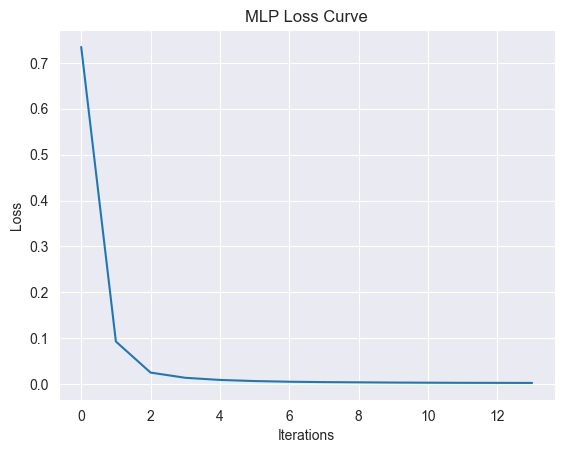

In [77]:
print("\nMelatih model MLP...")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50), # Example architecture
    activation='relu',
    solver='adam',
    alpha=1e-4,             # L2 regularization
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=500,           # Increased max iterations
    shuffle=True,
    random_state=42,
    tol=1e-4,
    early_stopping=True,    # Stop training when validation score doesn't improve
    n_iter_no_change=10,    # Number of iterations with no improvement to wait
    validation_fraction=0.1 # Use 10% of training data for early stopping validation
)
mlp_model.fit(X_train_transformed, y_train)
print("Model MLP selesai dilatih.")

# Evaluate on test set
print("\nEvaluasi MLP (Test Set):")
y_pred_mlp = mlp_model.predict(X_test_transformed)
print(classification_report(
    y_test,
    y_pred_mlp,
    target_names=list(reverse_mapping.values()),
    digits=6
))

# Plot loss curve
plt.plot(mlp_model.loss_curve_)
plt.title("MLP Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# Model Evaluation


=== Evaluating Model: Naive Bayes ===
>> Train Metrics:
   Accuracy : 0.984750
   Precision (Macro): 0.984917
   Recall    (Macro): 0.984750
   F1-score  (Macro): 0.984715
>> Test Metrics:
   Accuracy : 0.978333
   Precision (Macro): 0.978853
   Recall    (Macro): 0.978333
   F1-score  (Macro): 0.978240

>> Cross-Validation (5-fold on Training Data):
   Mean CV Accuracy: 0.982167 (+/- 0.003667)

>> Classification Report (Test Data - 6 Digits):
                    precision    recall  f1-score   support

    genuine_review   0.958494  0.993000  0.975442      1000
irrelevant_content   0.995781  0.944000  0.969199      1000
     explicit_spam   0.982283  0.998000  0.990079      1000

          accuracy                       0.978333      3000
         macro avg   0.978853  0.978333  0.978240      3000
      weighted avg   0.978853  0.978333  0.978240      3000


>> Generating Confusion Matrix...


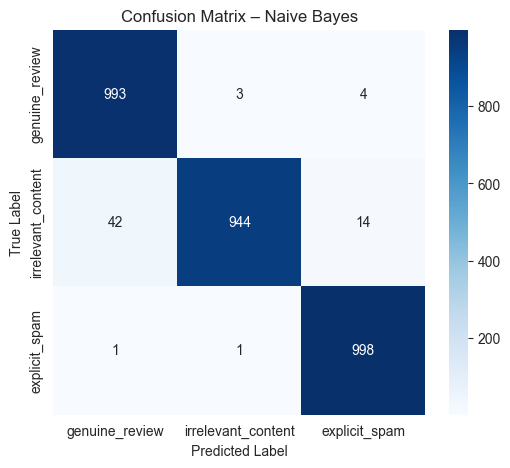


>> Generating Learning Curve...
   Learning Curve Mean Train Scores: ['0.961042', '0.980769', '0.982841', '0.982339', '0.984208']
   Learning Curve Mean Validation Scores: ['0.899583', '0.969000', '0.975750', '0.979750', '0.982167']


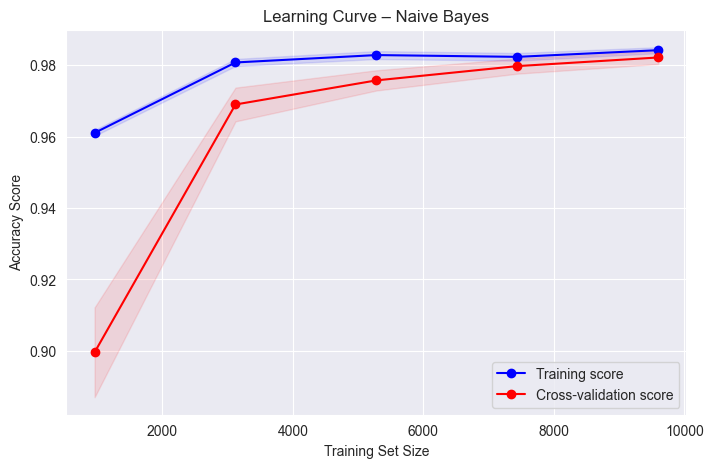


=== Evaluating Model: SVM ===
>> Train Metrics:
   Accuracy : 0.998500
   Precision (Macro): 0.998500
   Recall    (Macro): 0.998500
   F1-score  (Macro): 0.998500
>> Test Metrics:
   Accuracy : 0.995667
   Precision (Macro): 0.995671
   Recall    (Macro): 0.995667
   F1-score  (Macro): 0.995666

>> Cross-Validation (5-fold on Training Data):
   Mean CV Accuracy: 0.994667 (+/- 0.002494)

>> Classification Report (Test Data - 6 Digits):
                    precision    recall  f1-score   support

    genuine_review   0.993028  0.997000  0.995010      1000
irrelevant_content   0.994985  0.992000  0.993490      1000
     explicit_spam   0.998999  0.998000  0.998499      1000

          accuracy                       0.995667      3000
         macro avg   0.995671  0.995667  0.995666      3000
      weighted avg   0.995671  0.995667  0.995666      3000


>> Generating Confusion Matrix...


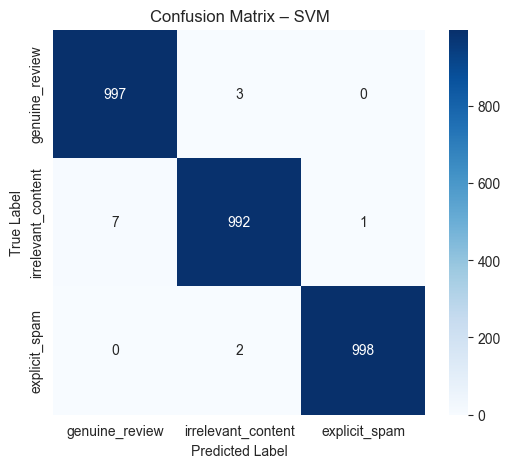


>> Generating Learning Curve...
   Learning Curve Mean Train Scores: ['1.000000', '0.999615', '0.999015', '0.998898', '0.998750']
   Learning Curve Mean Validation Scores: ['0.959167', '0.986667', '0.991000', '0.993417', '0.994667']


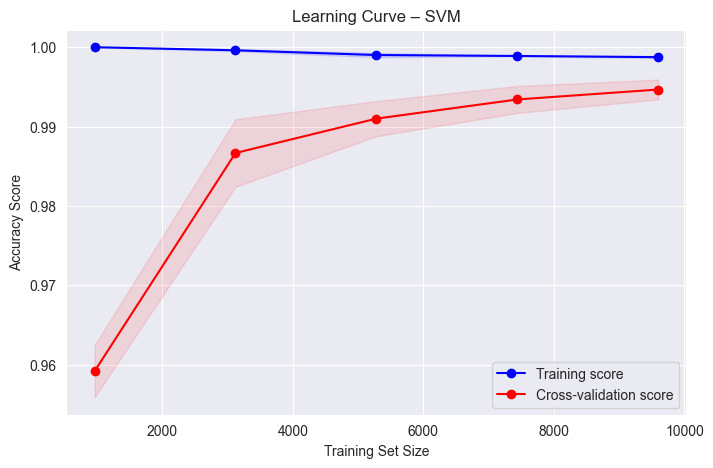


=== Evaluating Model: MLP ===
>> Train Metrics:
   Accuracy : 0.997333
   Precision (Macro): 0.997335
   Recall    (Macro): 0.997333
   F1-score  (Macro): 0.997333
>> Test Metrics:
   Accuracy : 0.993667
   Precision (Macro): 0.993725
   Recall    (Macro): 0.993667
   F1-score  (Macro): 0.993671

>> Cross-Validation (5-fold on Training Data):
   Mean CV Accuracy: 0.993833 (+/- 0.002550)

>> Classification Report (Test Data - 6 Digits):
                    precision    recall  f1-score   support

    genuine_review   0.985207  0.999000  0.992056      1000
irrelevant_content   0.996973  0.988000  0.992466      1000
     explicit_spam   0.998995  0.994000  0.996491      1000

          accuracy                       0.993667      3000
         macro avg   0.993725  0.993667  0.993671      3000
      weighted avg   0.993725  0.993667  0.993671      3000


>> Generating Confusion Matrix...


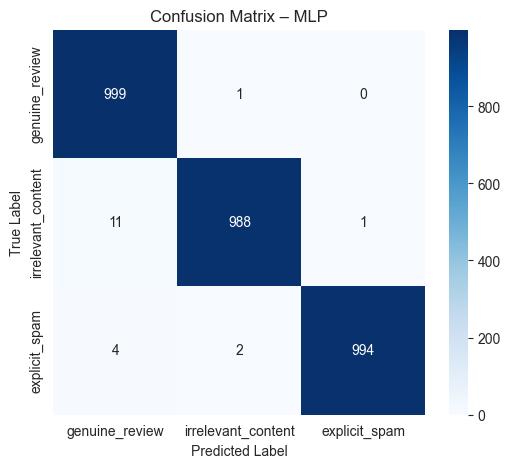


>> Generating Learning Curve...
   Learning Curve Mean Train Scores: ['0.996250', '0.997885', '0.998030', '0.999113', '0.998646']
   Learning Curve Mean Validation Scores: ['0.956917', '0.986583', '0.991167', '0.993667', '0.993833']


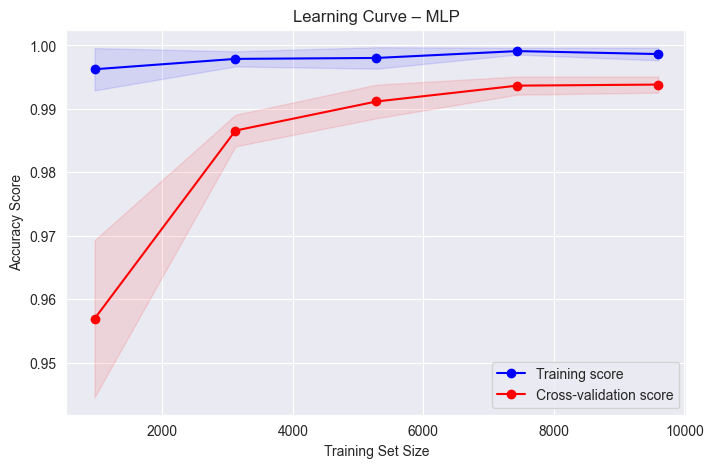

In [78]:
def evaluate_model_detailed(
    model, X_train, y_train, X_test, y_test,
    label_mapping,
    model_name
):
    print(f"\n=== Evaluating Model: {model_name} ===")

    # 1. Predictions
    try:
        y_pred_tr = model.predict(X_train)
        y_pred_te = model.predict(X_test)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return

    # 2. Basic Metrics (Train vs Test)
    print(">> Train Metrics:")
    try:
        print(f"   Accuracy : {accuracy_score(y_train, y_pred_tr):.6f}")
        print(f"   Precision (Macro): {precision_score(y_train, y_pred_tr, average='macro', zero_division=0):.6f}")
        print(f"   Recall    (Macro): {recall_score(y_train, y_pred_tr, average='macro', zero_division=0):.6f}")
        print(f"   F1-score  (Macro): {f1_score(y_train, y_pred_tr, average='macro', zero_division=0):.6f}")
    except Exception as e:
        print(f"   Error calculating train metrics: {e}")

    print(">> Test Metrics:")
    try:
        print(f"   Accuracy : {accuracy_score(y_test, y_pred_te):.6f}")
        print(f"   Precision (Macro): {precision_score(y_test, y_pred_te, average='macro', zero_division=0):.6f}")
        print(f"   Recall    (Macro): {recall_score(y_test, y_pred_te, average='macro', zero_division=0):.6f}")
        print(f"   F1-score  (Macro): {f1_score(y_test, y_pred_te, average='macro', zero_division=0):.6f}")
    except Exception as e:
        print(f"   Error calculating test metrics: {e}")

    # 3. Cross-Validation (on Training Data)
    print("\n>> Cross-Validation (5-fold on Training Data):")
    try:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        print(f"   Mean CV Accuracy: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")
    except Exception as e:
        print(f"   Could not perform cross-validation: {e}")


    # 4. Classification Report (on Test Data)
    print("\n>> Classification Report (Test Data - 6 Digits):")
    try:
        target_names_list = list(label_mapping.values())
        print(classification_report(
            y_test,
            y_pred_te,
            target_names=target_names_list,
            digits=6,
            zero_division=0
        ))
    except Exception as e:
        print(f"   Error generating classification report: {e}")

    # 5. Confusion Matrix (on Test Data)
    print("\n>> Generating Confusion Matrix...")
    try:
        cm = confusion_matrix(y_test, y_pred_te, labels=list(label_mapping.keys()))
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names_list, yticklabels=target_names_list)
        plt.title(f"Confusion Matrix – {model_name}")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    except Exception as e:
        print(f"   Error generating confusion matrix: {e}")

    # 6. Learning Curve (on Training Data)
    print("\n>> Generating Learning Curve...")
    try:
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train, cv=5, n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 5), # 5 points from 10% to 100%
            scoring='accuracy'
        )
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)

        print(f"   Learning Curve Mean Train Scores: {[f'{s:.6f}' for s in train_mean]}")
        print(f"   Learning Curve Mean Validation Scores: {[f'{s:.6f}' for s in val_mean]}")

        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
        plt.plot(train_sizes, val_mean, 'o-', color='red', label='Cross-validation score')
        plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
        plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
        plt.title(f"Learning Curve – {model_name}")
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy Score")
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"   Could not generate learning curve: {e}")

evaluate_model_detailed(nb_model, X_train_transformed, y_train, X_test_transformed, y_test, reverse_mapping, 'Naive Bayes')
evaluate_model_detailed(svm_model, X_train_transformed, y_train, X_test_transformed, y_test, reverse_mapping, 'SVM')
evaluate_model_detailed(mlp_model, X_train_transformed, y_train, X_test_transformed, y_test, reverse_mapping, 'MLP')


## Save Artifacts

In [73]:
dump_dir = '../../models_dump/spam_detection_dump'
os.makedirs(dump_dir, exist_ok=True)
print(f"\nMenyimpan artefak ke direktori: {dump_dir}")

# 1. Save the combined feature pipeline (FeatureUnion)
pipeline_path = os.path.join(dump_dir, 'feature_pipeline.pkl')
joblib.dump(combined_features_pipeline, pipeline_path)
print(f"- Pipeline fitur disimpan ke: {pipeline_path}")

# 2. Save the trained models
nb_model_path = os.path.join(dump_dir, 'naive_bayes_model.pkl')
joblib.dump(nb_model, nb_model_path)
print(f"- Model Naive Bayes disimpan ke: {nb_model_path}")

svm_model_path = os.path.join(dump_dir, 'svm_model.pkl')
joblib.dump(svm_model, svm_model_path)
print(f"- Model SVM disimpan ke: {svm_model_path}")

mlp_model_path = os.path.join(dump_dir, 'mlp_model.pkl')
joblib.dump(mlp_model, mlp_model_path)
print(f"- Model MLP disimpan ke: {mlp_model_path}")

# 3. Save the label mappings
mapping_path = os.path.join(dump_dir, 'label_mapping.pkl')
joblib.dump(custom_mapping, mapping_path)
print(f"- Mapping label (str -> int) disimpan ke: {mapping_path}")

reverse_mapping_path = os.path.join(dump_dir, 'reverse_label_mapping.pkl')
joblib.dump(reverse_mapping, reverse_mapping_path)
print(f"- Reverse mapping label (int -> str) disimpan ke: {reverse_mapping_path}")

print("\nSemua artifacts berhasil disimpan.")


Menyimpan artefak ke direktori: ../../models_dump/spam_detection_dump
- Pipeline fitur disimpan ke: ../../models_dump/spam_detection_dump\feature_pipeline.pkl
- Model Naive Bayes disimpan ke: ../../models_dump/spam_detection_dump\naive_bayes_model.pkl
- Model SVM disimpan ke: ../../models_dump/spam_detection_dump\svm_model.pkl
- Model MLP disimpan ke: ../../models_dump/spam_detection_dump\mlp_model.pkl
- Mapping label (str -> int) disimpan ke: ../../models_dump/spam_detection_dump\label_mapping.pkl
- Reverse mapping label (int -> str) disimpan ke: ../../models_dump/spam_detection_dump\reverse_label_mapping.pkl

Semua artifacts berhasil disimpan.


# Testing

In [79]:
def predict_spam_all_models(
    raw_texts,           # List of raw text strings
    dump_dir,            # Directory containing ALL artifacts (pipeline, models, mapping)
    true_labels=None     # Optional: List of true labels for evaluation
):
    print(f"\n--- Starting Prediction Process from Directory: {dump_dir} ---")

    pipeline_path = os.path.join(dump_dir, 'feature_pipeline.pkl')
    reverse_mapping_path = os.path.join(dump_dir, 'reverse_label_mapping.pkl')

    # Dictionary mapping user-friendly names to model filenames
    model_files = {
        'Naive Bayes': 'naive_bayes_model.pkl',
        'SVM': 'svm_model.pkl',
        'MLP': 'mlp_model.pkl'
    }

    # --- 1. Load Essential Artifacts (Pipeline & Mapping) ---
    try:
        feature_pipeline = joblib.load(pipeline_path)
        reverse_mapping = joblib.load(reverse_mapping_path)
        print(f"Pipeline fitur dari {pipeline_path} berhasil dimuat.")
        print(f"Mapping label dari {reverse_mapping_path} berhasil dimuat.")
    except FileNotFoundError as e:
        print(f"Error: File esensial tidak ditemukan: {e}")
        print("Pastikan 'feature_pipeline.pkl' dan 'reverse_label_mapping.pkl' ada di direktori.")
        return None
    except Exception as e:
        print(f"Error loading essential artifacts: {e}")
        return None

    # --- 2. Prepare Input DataFrame ---
    df_input = pd.DataFrame({'raw_text': raw_texts})
    if true_labels:
        # Map true labels to encoded format if needed for some internal checks later
        # For evaluation, we'll use the string format directly with reverse_mapping keys
        df_input['true_label_str'] = true_labels
        print("True labels provided for evaluation.")


    # --- 3. Apply Feature Pipeline (Once) ---
    print("\nMenerapkan pipeline fitur ke data baru...")
    try:
        X_transformed = feature_pipeline.transform(df_input['raw_text'])
        print(f"Shape data setelah transformasi: {X_transformed.shape}")
    except Exception as e:
        print(f"Error applying feature pipeline: {e}")
        return None

    # --- 4. Loop Through Models, Load, Predict, and Store Results ---
    all_results = {} # Dictionary to store results DataFrame for each model

    print("\n--- Predicting with Available Models ---")
    for model_name, model_filename in model_files.items():
        model_path = os.path.join(dump_dir, model_filename)

        # Check if model file exists
        if not os.path.exists(model_path):
            print(f"\n--- Skipping Model: {model_name} (File not found at {model_path}) ---")
            continue

        print(f"\n--- Processing Model: {model_name} ---")
        try:
            # Load the current model
            model = joblib.load(model_path)
            print(f"   Model {model_name} dari {model_path} berhasil dimuat.")

            # Create a copy of the input df for this model's results
            df_model_results = df_input.copy()

            # Predict using the loaded model
            print("   Melakukan prediksi...")
            predictions_int = model.predict(X_transformed)
            df_model_results['predicted_label'] = [reverse_mapping.get(p, 'Unknown') for p in predictions_int]

            # Get Probabilities (if possible)
            if hasattr(model, 'predict_proba'):
                print("   Mendapatkan probabilitas...")
                try:
                    probabilities = model.predict_proba(X_transformed)
                    class_order_int = model.classes_
                    class_order_str = [reverse_mapping.get(c, f'Class_{c}') for c in class_order_int]

                    for i, label in enumerate(class_order_str):
                        df_model_results[f'proba_{label}'] = probabilities[:, i]
                except Exception as e_proba:
                    print(f"   Warning: Gagal mendapatkan probabilitas untuk {model_name}: {e_proba}")
            else:
                print(f"   Model {model_name} tidak memiliki metode predict_proba.")

            # Store the results DataFrame for this model
            all_results[model_name] = df_model_results

        except Exception as e_model:
            print(f"   Error processing model {model_name}: {e_model}")
            # Continue to the next model

    # --- 5. Display Combined Results & Evaluate (Optional) ---
    print("\n" + "="*70)
    print("--- Summary of Predictions ---")
    print("="*70)

    if not all_results:
        print("Tidak ada model yang berhasil diproses.")
        return None

    for i in range(len(raw_texts)):
        print(f"\n{i+1}. Text: {raw_texts[i]}")
        if true_labels:
            print(f"   True Label: {true_labels[i]}")
        print(  "   ------------------------------------")
        for model_name, result_df in all_results.items():
            pred_label = result_df.loc[i, 'predicted_label']
            prob_strs = []
            proba_cols = [col for col in result_df.columns if col.startswith('proba_')]
            if proba_cols:
                prob_strs = [f"{col.split('_', 1)[1]}: {result_df.loc[i, col]*100:5.2f}%"
                             for col in proba_cols]
            conf_str = "  ".join(prob_strs)

            print(f"   Model: {model_name:<12} Predicted: {pred_label:<20}", end="")
            if conf_str:
                print(f" Confidence: [{conf_str}]")
            else:
                print()

    # Optional Evaluation if true_labels were provided
    if true_labels:
        print("\n" + "="*70)
        print("--- Evaluation Summary (vs True Labels) ---")
        print("="*70)
        for model_name, result_df in all_results.items():
            print(f"\n--- Evaluation for Model: {model_name} ---")
            try:
                report = classification_report(
                    result_df['true_label_str'],
                    result_df['predicted_label'],
                    digits=4,
                    zero_division=0
                )
                print(report)
            except Exception as e_eval:
                print(f"   Error generating evaluation report for {model_name}: {e_eval}")

    return all_results

In [84]:
samples = [
    "Aplikasinya sangat membantu untuk mengedit foto.",
    "Bagaimana kabar hari ini?",
    "Dapatkan voucher gratis kode ABC123 sekarang!",
    "aneh",
    "semua urusan lebih gampang banget dengan gopay",
    "bayar pake gopay semua jadi lebih murah",
    "Cepat di acc",
    "Min ah kacau bet saya mau login gopay ulang karena HP keriset malah suruh vermuk yg dimna muka itu punya temen jauh saya jdi kgk bisa login gimna nih buset dh klo gini crnya ilang akun gopay saya",
    "Semoga gratis selama nya yaaaa",
    "saya sangat senang transaksi pakai gopai karena gak ribet.",
    "layanan yang cukup memuaskan",
    "Fasilitas yg sangat mudah",
    "Via tf sesama gopay nya lelet bgttt , tolong perbaikin minðŸ™�",
    "yang baru belajar uang digital, Gopay mempermudah transaksi banget siðŸ«°",
    "Bagus bisa juga buat bayar greb bike",
    "moga di GoPay tidak ada Hacker seperti di akun Dana",
    "kenapa tiba ngelag banget sampai ga bisa melakukan pembayaran, padahal kuota saya full dan bisa membuka aplikasi yang lain. tolong diperbaiki",
    "ok. dan simple",
    "Faster and Better... ðŸ«° Okey deh..",
    "Sangat puas sekali dan menguntungkan dan bikinnyaman dan aman sentosa... terimakasih gopay..",
    "Baguss & cepat",
    "Cepat buat transver",
    "Aplikasinya bagus banget, fiturnya lengkap dan mudah dipakai!",
    "DISKON BESAR!! Klik link ini segera bit.ly/promo123 jangan sampai kehabisan!",
    "Min, kok app nya sering force close ya di hp saya? Tolong diperbaiki.",
    "Jual pulsa murah WA 081234567890",
    "Hari ini cuaca cerah sekali.",
    "Gamenya seru tapi iklannya banyak banget mengganggu.",
    "Saya tidak mengerti cara menggunakan fitur X, bisa tolong jelaskan?",
    "Mantap jiwaaaaaa 👍👍👍👍👍",
    "qwerty asdfgh zxcvb",
    "Lebih bagus dari aplikasi sebelah yg lemot itu.",
    "joki mobile legends hanya di http://ourastore.com ASIKKK"
]

artifacts_dump_dir = '../../models_dump/spam_detection_dump'

print("\n--- Memulai Prediksi dengan SEMUA Model ---")
prediction_results = predict_spam_all_models(
    raw_texts=samples,
    dump_dir=artifacts_dump_dir,
    true_labels=None
)


--- Memulai Prediksi dengan SEMUA Model ---

--- Starting Prediction Process from Directory: ../../models_dump/spam_detection_dump ---
Pipeline fitur dari ../../models_dump/spam_detection_dump\feature_pipeline.pkl berhasil dimuat.
Mapping label dari ../../models_dump/spam_detection_dump\reverse_label_mapping.pkl berhasil dimuat.

Menerapkan pipeline fitur ke data baru...


Pandas Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Shape data setelah transformasi: (33, 5028)

--- Predicting with Available Models ---

--- Processing Model: Naive Bayes ---
   Model Naive Bayes dari ../../models_dump/spam_detection_dump\naive_bayes_model.pkl berhasil dimuat.
   Melakukan prediksi...
   Mendapatkan probabilitas...

--- Processing Model: SVM ---
   Model SVM dari ../../models_dump/spam_detection_dump\svm_model.pkl berhasil dimuat.
   Melakukan prediksi...
   Mendapatkan probabilitas...

--- Processing Model: MLP ---
   Model MLP dari ../../models_dump/spam_detection_dump\mlp_model.pkl berhasil dimuat.
   Melakukan prediksi...
   Mendapatkan probabilitas...

--- Summary of Predictions ---

1. Text: Aplikasinya sangat membantu untuk mengedit foto.
   ------------------------------------
   Model: Naive Bayes  Predicted: genuine_review       Confidence: [genuine_review: 71.03%  irrelevant_content: 17.61%  explicit_spam: 11.36%]
   Model: SVM          Predicted: genuine_review       Confidence: [genuine_review: 84.47%  ir